In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer


# First we check the format of llama 2, how it takes the promt

System Prompt (optional) to guide the model

User prompt (required) to give the instruction

Model Answer (required)

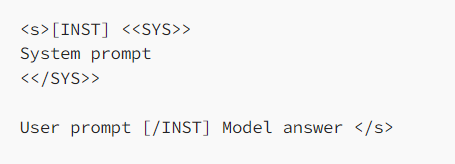

In [2]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64   # b----> M,R AND A-----> R,N SO, R is basically 64

# Alpha parameter for LoRA scaling
lora_alpha = 16   # Tell how much influence the new matrix has in original one

# Dropout probability for LoRA layers
lora_dropout = 0.1   #The dropout rate in LoRA layers to prevent overfitting by randomly ignoring some of the data during training.

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True  #Activates 4-bit precision, which reduces memory usage.

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"  #Sets the computation data type to "float16" for the 4-bit model.

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
#Whether to use mixed precision training to speed up computation. None is enabled here.
fp16 = False
bf16 = False

# Batch size per GPU for training
#How many examples each GPU will process at a time during training and evaluation.
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1  #If set, this is the maximum number of training steps to run, overriding the epoch setting.

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [6]:
from transformers import TrainingArguments, AutoModelForCausalLM, AutoTokenizer, Trainer
from datasets import load_dataset

# Load dataset
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model for CPU
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Adjust tokenizer settings for CPU training
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters for CPU
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    no_cuda=True,  # Ensure that CUDA is disabled
    report_to="tensorboard"
)

# Initialize the trainer for CPU
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset,
    tokenizer=tokenizer
)

# Train the model on CPU
trainer.train()
